In [19]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/plant-seedlings-classification/sample_submission.csv
/kaggle/input/plant-seedlings-classification/train/Fat Hen/cd16fe7e4.png
/kaggle/input/plant-seedlings-classification/train/Fat Hen/020ac5b06.png
/kaggle/input/plant-seedlings-classification/train/Fat Hen/4a44a00eb.png
/kaggle/input/plant-seedlings-classification/train/Fat Hen/79cec7209.png
/kaggle/input/plant-seedlings-classification/train/Fat Hen/5f24e1079.png
/kaggle/input/plant-seedlings-classification/train/Fat Hen/11e40532a.png
/kaggle/input/plant-seedlings-classification/train/Fat Hen/7894abcbb.png
/kaggle/input/plant-seedlings-classification/train/Fat Hen/1688c9a5f.png
/kaggle/input/plant-seedlings-classification/train/Fat Hen/a258e82f2.png
/kaggle/input/plant-seedlings-classification/train/Fat Hen/bd3b1cb2e.png
/kaggle/input/plant-seedlings-classification/train/Fat Hen/cbdb42238.png
/kaggle/input/plant-seedlings-classification/train/Fat Hen/5cc2862dc.png
/kaggle/input/plant-seedlings-classification/train/Fat He

/kaggle/input/plant-seedlings-classification/train/Charlock/bef36ff4f.png
/kaggle/input/plant-seedlings-classification/train/Charlock/fd5021432.png
/kaggle/input/plant-seedlings-classification/train/Charlock/e23998a9b.png
/kaggle/input/plant-seedlings-classification/train/Charlock/88c8cbb35.png
/kaggle/input/plant-seedlings-classification/train/Charlock/da2aa8585.png
/kaggle/input/plant-seedlings-classification/train/Charlock/97907da1a.png
/kaggle/input/plant-seedlings-classification/train/Charlock/c97f86135.png
/kaggle/input/plant-seedlings-classification/train/Charlock/eeee9e96c.png
/kaggle/input/plant-seedlings-classification/train/Charlock/167202290.png
/kaggle/input/plant-seedlings-classification/train/Charlock/88c5a0b11.png
/kaggle/input/plant-seedlings-classification/train/Charlock/25cab77ab.png
/kaggle/input/plant-seedlings-classification/train/Charlock/3b2ae0151.png
/kaggle/input/plant-seedlings-classification/train/Charlock/7f6d9ef11.png
/kaggle/input/plant-seedlings-classifi

/kaggle/input/plant-seedlings-classification/train/Loose Silky-bent/fe944dee4.png
/kaggle/input/plant-seedlings-classification/train/Loose Silky-bent/8fb04526c.png
/kaggle/input/plant-seedlings-classification/train/Loose Silky-bent/230461e8b.png
/kaggle/input/plant-seedlings-classification/train/Loose Silky-bent/cc3f7e692.png
/kaggle/input/plant-seedlings-classification/train/Loose Silky-bent/b396ce363.png
/kaggle/input/plant-seedlings-classification/train/Loose Silky-bent/10250b3ac.png
/kaggle/input/plant-seedlings-classification/train/Loose Silky-bent/2b85ff393.png
/kaggle/input/plant-seedlings-classification/train/Loose Silky-bent/3fd2b83fc.png
/kaggle/input/plant-seedlings-classification/train/Loose Silky-bent/3a39e5bc5.png
/kaggle/input/plant-seedlings-classification/train/Loose Silky-bent/74425d617.png
/kaggle/input/plant-seedlings-classification/train/Loose Silky-bent/91c7359d1.png
/kaggle/input/plant-seedlings-classification/train/Loose Silky-bent/bcc2bbc1d.png
/kaggle/input/pl

/kaggle/input/plant-seedlings-classification/test/0dba99002.png
/kaggle/input/plant-seedlings-classification/test/3d65168c2.png
/kaggle/input/plant-seedlings-classification/test/b7192c70f.png
/kaggle/input/plant-seedlings-classification/test/d6d31dcbe.png
/kaggle/input/plant-seedlings-classification/test/01291174f.png
/kaggle/input/plant-seedlings-classification/test/808cf55c6.png
/kaggle/input/plant-seedlings-classification/test/0fb233ad6.png
/kaggle/input/plant-seedlings-classification/test/b3d6fdb80.png
/kaggle/input/plant-seedlings-classification/test/b2706e2b3.png
/kaggle/input/plant-seedlings-classification/test/d0152bd7c.png
/kaggle/input/plant-seedlings-classification/test/0c51bf229.png
/kaggle/input/plant-seedlings-classification/test/a544fc46d.png
/kaggle/input/plant-seedlings-classification/test/25fa8d109.png
/kaggle/input/plant-seedlings-classification/test/5315c2dca.png
/kaggle/input/plant-seedlings-classification/test/2126dc71b.png
/kaggle/input/plant-seedlings-classifica

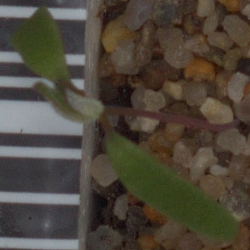

In [20]:
from PIL import Image

Image.open("/kaggle/input/plant-seedlings-classification/test/86f08e6d1.png")

In [21]:
pd.options.display.max_colwidth = 500

import glob

path = glob.glob("/kaggle/input/plant-seedlings-classification/train/*/*")   

train = pd.DataFrame({"path":path})

train["answer"] = train["path"].apply(lambda x : x.split("/")[5])
train

,path,answer
0,/kaggle/input/plant-seedlings-classification/train/Fat Hen/cd16fe7e4.png,Fat Hen
1,/kaggle/input/plant-seedlings-classification/train/Fat Hen/020ac5b06.png,Fat Hen
2,/kaggle/input/plant-seedlings-classification/train/Fat Hen/4a44a00eb.png,Fat Hen
3,/kaggle/input/plant-seedlings-classification/train/Fat Hen/79cec7209.png,Fat Hen
4,/kaggle/input/plant-seedlings-classification/train/Fat Hen/5f24e1079.png,Fat Hen
...,...,...
4745,/kaggle/input/plant-seedlings-classification/train/Common Chickweed/4d6cbfb1e.png,Common Chickweed
4746,/kaggle/input/plant-seedlings-classification/train/Common Chickweed/ddbd81175.png,Common Chickweed
4747,/kaggle/input/plant-seedlings-classification/train/Common Chickweed/aa8778e2d.png,Common Chickweed
4748,/kaggle/input/plant-seedlings-classification/train/Common Chickweed/1640f4ae3.png,Common Chickweed


In [22]:
from sklearn.model_selection import train_test_split

x_train, x_valid = train_test_split(train, test_size = 0.2, random_state = 1, stratify = train["answer"])

In [23]:
from keras.preprocessing.image import ImageDataGenerator

# 이번 대회는 데이터가 적어서 늘려줘야한다. (4750개)

# ** data augmentaion (데이터 증강)
# 1. 강아지 사진이 왼쪽을 보고있으면, 위,아래,오른쪽을 보는 강아지 사진은 구분을 잘 못하는 것을 해소해준다.
# 2. 과대적합 방지

idg = ImageDataGenerator(horizontal_flip = True)
# 1. horizontal_flip옵션 : 좌우 반전, epochs마다 50%확률로 좌우반전된 데이터를 학습시킨다. -> epochs를 최소 2번이상은 해줘야함, 일반적으로 도움됨
# 2. vertical_flip옵션 : 상하 반전
# *주의 : 둘다 적용시키는 것은 지양 / 상하,좌우반전 옵션을 둘 다 넣었다가 둘 다 적용되면 데이터가 너무 변형되서 안 좋아 질 수도 있다.
#         각각 하나씩 적용시킨 모델을 앙상블하면 좋다.
#        - 대신 사이즈가 크면 너무 오래걸릴 수 있다.

train_generator = idg.flow_from_dataframe(x_train, x_col = "path", y_col = "answer", batch_size = 64, target_size = (256,256))
valid_generator = idg.flow_from_dataframe(x_valid, x_col = "path", y_col = "answer", batch_size = 64 , target_size = (256,256))


Found 3800 validated image filenames belonging to 12 classes.
Found 950 validated image filenames belonging to 12 classes.


In [24]:
!pip install -U git+https://github.com/qubvel/efficientnet
    
# efficientnet모델 : dropout, conv, maxpooling등.. 잘 쌓여있다.

  Cloning https://github.com/qubvel/efficientnet to /tmp/pip-req-build-xrmpobnw
  Running command git clone -q https://github.com/qubvel/efficientnet /tmp/pip-req-build-xrmpobnw
  Created wheel for efficientnet: filename=efficientnet-1.1.0-py3-none-any.whl size=18397 sha256=6e130b17e8c12adb6ffa8ead4dc2ec24bd44965549931ebe92edab04018d6fb3
  Stored in directory: /tmp/pip-ephem-wheel-cache-evls72z6/wheels/11/69/85/814d64d694c96db0eef17b718042d644a1e54f113920481920
Successfully built efficientnet
  Attempting uninstall: efficientnet
    Found existing installation: efficientnet 1.1.0
    Uninstalling efficientnet-1.1.0:
      Successfully uninstalled efficientnet-1.1.0


In [25]:
# eff = EfficientNetB0(weights = "imagenet", include_top = False, pooling = "avg")
# eff.summary()

In [26]:
# 개선법
# 1. 이미지 사이즈 증가 
# 2. learing_rate 줄이기
# 3. 다중분류 일시 이미지size와 batch_size 조정, ex) 12개 클래스 -> batch_size 일반적으로 32이상
# 4. 모델선택 ex) efficientnet
# 5. optimizer 조정
# 6. ensemble하기(bagging), 이유 : 딥러닝모델은 값이 항상 일정하지 않아서

In [27]:
from efficientnet.tfkeras import EfficientNetB0 
from keras import Sequential
from keras.layers import *
from keras.callbacks import ReduceLROnPlateau,ModelCheckpoint,EarlyStopping

mc = ModelCheckpoint("best.h5", save_best_only = True)
es = EarlyStopping(patience = 3)
rl = ReduceLROnPlateau(patience = 2, factor = 0.1, verbose = 1)

model = Sequential()

model.add(EfficientNetB0(weights = "imagenet", include_top = False, pooling = "avg"))
# weight : 가중치
# include_top : 출력층은 알아서 한다. False
# pooling : 일반적으로 global_avg_pooling, 
#           출력층은 보통 Dense layer인데 1차원이라 연결이 안됨, 근데 이걸 Flatten()으로 연결하면 지엽적인 정보 날아감

model.add(Dense(12, activation = "softmax"))

model.compile(metrics = ["acc"], loss = "categorical_crossentropy" , optimizer = "adam")

model.fit(train_generator, validation_data = valid_generator, epochs = 5, callbacks = [es,mc,rl])


Epoch 1/5
60/60 [==============================] - 95s 2s/step - loss: 0.6039 - acc: 0.8024 - val_loss: 1.2777 - val_acc: 0.6811 - lr: 0.0010
Epoch 2/5
60/60 [==============================] - 81s 1s/step - loss: 0.1955 - acc: 0.9332 - val_loss: 1.1504 - val_acc: 0.7547 - lr: 0.0010
Epoch 3/5
60/60 [==============================] - 80s 1s/step - loss: 0.0918 - acc: 0.9695 - val_loss: 0.4417 - val_acc: 0.8947 - lr: 0.0010
Epoch 4/5
60/60 [==============================] - 80s 1s/step - loss: 0.0980 - acc: 0.9663 - val_loss: 0.3563 - val_acc: 0.9053 - lr: 0.0010
Epoch 5/5
60/60 [==============================] - 81s 1s/step - loss: 0.0742 - acc: 0.9768 - val_loss: 0.2025 - val_acc: 0.9505 - lr: 0.0010


In [28]:
test = pd.DataFrame({"path":os.listdir("/kaggle/input/plant-seedlings-classification/test")})
test["path"] = "/kaggle/input/plant-seedlings-classification/test/"+test["path"]
test

idg2 = ImageDataGenerator()
# test time augmentation기법도 있다
test_generator = idg2.flow_from_dataframe(test,x_col = "path", y_col = None, batch_size = 64, target_size=(256,256), class_mode = None, shuffle = False)

model.load_weights("best.h5")
result = model.predict(test_generator)

Found 794 validated image filenames.


In [29]:
sub = pd.read_csv("/kaggle/input/plant-seedlings-classification/sample_submission.csv")
sub.head()

,file,species
0,0021e90e4.png,Sugar beet
1,003d61042.png,Sugar beet
2,007b3da8b.png,Sugar beet
3,0086a6340.png,Sugar beet
4,00c47e980.png,Sugar beet


In [30]:
result = result.argmax(1)
category = sorted(train["answer"].unique())

a = [category[result[i]] for i in range(len(test))]

In [31]:
sub["species"] = a
sub.head()

,file,species
0,0021e90e4.png,Sugar beet
1,003d61042.png,Common Chickweed
2,007b3da8b.png,Common wheat
3,0086a6340.png,Scentless Mayweed
4,00c47e980.png,Fat Hen


In [35]:
sub["file"] = test_generator.filenames
sub["file"] = sub["file"].apply(lambda x : x.split("/")[5])
sub.head()

,file,species
0,0dba99002.png,Sugar beet
1,3d65168c2.png,Common Chickweed
2,b7192c70f.png,Common wheat
3,d6d31dcbe.png,Scentless Mayweed
4,01291174f.png,Fat Hen


In [34]:
sub.to_csv("sub.csv", index = False)